Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [44]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
%matplotlib qt 
#%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [27]:
# model_name ='test'
# model_name = 'mtm_3links'
# model_name = 'mtm'
# model_name = 'mtm_spring'
#model_name = 'mtm_2spring'
#model_name = 'mtm_2spring_tendon'
# model_name = 'mtm_4links_parallel'
# model_name = 'mtm_3links_parallel'

#model_name = 'psm_no_off_minert'
model_name = 'psm_complete'


model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [28]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

dh = []
springs = []
friction_type = []
tendon_couplings = []


if model_name =='test':
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, False),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, False)]
    q = q1
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s]
    friction_type = ['Coulomb', 'viscous', 'offset']
elif model_name == 'mtm':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    #springs = [tau_s]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print("MTM")
elif model_name == 'mtm_spring':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
elif model_name == 'mtm_2spring':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s, -q4]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
elif model_name == 'mtm_2spring_tendon':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s, -q4]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    tendon_couplings = [(4, 3, 2.0/3.0)] # tau_3 += 2/3*tau_4
    print(model_name)
elif model_name == 'mtm_3links_parallel':
    # define paralelogram coordinate relation
    q3 = -q2 + q4
    q5 = -q4 + q2
    q6 = q4 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,4],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.2794, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   1,  [5],    0,     -_pi/2, 0,        q4+_pi,   True,  False, True),
          (5,   4,  [6],   0.1,   0,      0,        q5-_pi/2, True,  False, True),
          (6,   5,  [],     0.2794, 0,      0,        q6,      False, False, True)]
    friction_type = ['Coulomb', 'viscous', 'offset']
    #springs = [q1, q2, q3]
elif model_name == 'mtm_4links_parallel':
    # define paralelogram coordinate relation
    q3 = -q2 + q5
    q6 = -q5 + q2
    q7 = q5 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,5],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [0],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   1,  [6],     0,     -_pi/2, 0,        q5+_pi,   True,  False, True),
          (6,   5,  [7],   0.1,   0,      0,        q6-_pi/2, True,  False, True),
          (7,   6,  [],     0.279, 0,      0,        q7,      False, False, True)]
    friction_type = ['Coulomb', 'viscous']
elif model_name == 'mtm_3links':
    dh = [(0,   -1, [1],    0,      0,      0,          0,         False, False, False),
          (1,   0,  [2],    0,      0,      -0.21537,   q1,        True,  False, True),
          (2,   1,  [3],    0,      -_pi/2, 0,          q2+_pi/2,  True,  False, True),
          (3,   2,  [4],    0.279,  0,      0,          q3+_pi/2,  True,  True,  True)]
    # springs = [q1]
    friction_type = ['Coulomb', 'viscous']
elif (model_name == 'psm_no_off_minert'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    x = [None]*12
    x[0]  = ( 0,  -1,  [1],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [4, 7], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back                                  )
    x[4]  = ( 4,   3,  [5],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[5]  = ( 5,   4,  [6],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[6]  = ( 6,   5, [9],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[7]  = ( 7,   3, [8],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[8]  = ( 8,  7,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    x[9] = (9,   6, [10],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[10] = (10,  9, [11],          0, -sympy.pi/2,     0,          -sympy.pi/2+q5, False,  True,  True) # Tool Pitch
    x[11] = (11,  10, [12,13],  0.0091, -sympy.pi/2,     0,          -sympy.pi/2+q6, False,  True,  True) # Tool Yaw
    #x[12] = (12,  11, [],            0,           0,     0,                     -q7, False, False,  True) # Gripper1
    #x[13] = (13,  11, [],            0,           0,     0,                      q7, False,  True,  True) # Gripper2
    dh = x
    friction_type = ['Coulomb', 'viscous']
    print(model_name)
    
elif (model_name == 'psm_complete'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    x = [None]*15
    x[0]  = ( 0,  -1,  [1],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3, 4, 5],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [6, 10], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back
    x[4]  = ( 4,   2,  [] ,     0.0664,           0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Front                                    )
    x[5]  = ( 5,   2,  [7],    -0.0296,           0,     0,   q2-beta2 - sympy.pi/2, False, False, False)    # Intermediate
    x[6]  = ( 6,   3,  [8],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[7]  = ( 7,   5,   [],     0.1842,           0,     0,    -q2+beta2+sympy.pi/2,  True, False,  True)    # Pitch Top
    x[8]  = ( 8,   6,  [9],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[9]  = ( 9,   8, [12],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[10] = (10,   3, [11],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[11] = (11,  10,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    
    x[12] = (12,   9, [13],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[13] = (13,  12, [14],          0, -sympy.pi/2,     0,          -sympy.pi/2+q5, False,  True,  True) # Tool Pitch
    x[14] = (14,  13, [15,16],  0.0091, -sympy.pi/2,     0,          -sympy.pi/2+q6, False,  True,  True) # Tool Yaw
    #x[15] = (15,  14, [],            0,           0,     0,                     -q7, False, False,  True) # Gripper1
    #x[16] = (16,  15, [],            0,           0,     0,                      q7, False,  True,  True) # Gripper2
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
else:
    raise Exception("No robot name matches " + name)
print(friction_type)
robot_def = RobotDef(dh,
                     springs=springs,
                     tendon_couplings=tendon_couplings,
                     dh_convention='mdh',
                     friction_type=friction_type)

psm_complete
['Coulomb', 'viscous', 'offset']


In [29]:
robot_def.dq_for_frame

In [30]:
robot_def.coordinates_joint_type

['R', 'R', 'P', 'R', 'R', 'R']

In [23]:
robot_def.bary_params

In [31]:
robot_def.K

## Create kinematics chain

In [32]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
CPU times: user 5min 39s, sys: 1.55 s, total: 5min 40s
Wall time: 5min 39s


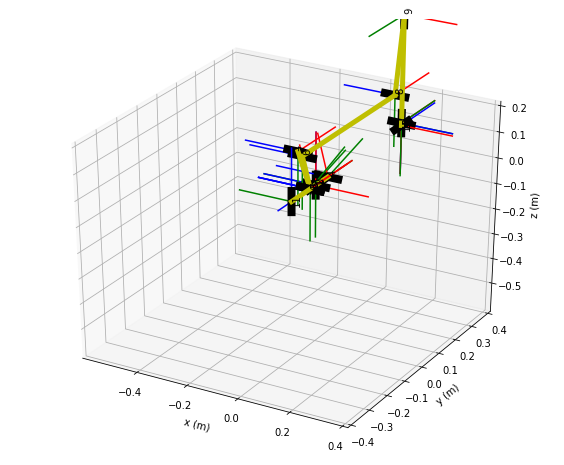

In [33]:
angle = [0, 0, 0, 0, 0, 0, 0]
geom.draw_geom(angle)

## Create dynamics

In [37]:
dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/14
Calculating the link kinetic energy of 3/14
Calculating the link kinetic energy of 4/14
Calculating the link kinetic energy of 6/14
Calculating the link kinetic energy of 7/14
Calculating the link kinetic energy of 8/14
Calculating the link kinetic energy of 9/14
Calculating the link kinetic energy of 11/14
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
Adding frictions and springs...
Add tendon coupling torque and motor inertia...
Calculating gregressor...
('input_vars', (q1, q2, q3, q4, q5, q6, dq1, dq2, dq3, dq4, dq5, dq6, ddq1, ddq2, ddq3, ddq4, ddq5, ddq6))
Calculating M, C and G...
Calculating base parameter...
[ 87  86  85 100  84  99  97  98  59  14  69  67  13  24 107 105  89 113
 109 111  31 115  11  29   6 114 110 106  38  12  90  10 112 108 104  36
  88  46  71  72  47  82   7  19  20  30  60  28  65  68  27  66  52  78
  26  61  77 102  48 103  37  80  16  79 101

In [38]:
robot_def.bary_params

In [39]:
sympy.Matrix(dyn.base_param)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [40]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 38 parameters


In [41]:
for tendon_coupling in dyn.rbt_def.tendon_couplings:
    src_frame, dst_frame, k = tendon_coupling
    dq_src = dyn.rbt_def.dq_for_frame[src_frame]
    dq_dst = dyn.rbt_def.dq_for_frame[dst_frame]
    src_index = dyn.rbt_def.d_coordinates.index(dq_src)

    for a in range(len(dyn.rbt_def.d_coordinates)):
        dq_da = sympy.diff(dq_dst, dyn.rbt_def.d_coordinates[a])
        #tau_c[a] += dq_da * k * tau_csf[src_index]
        print(a, dq_da, k)
dyn.rbt_def.tendon_couplings 
2/3

---
# 3 - Excitation trajectory optimization

In [308]:
# model_name = 'test_psm_long2'
# model_name ='test'
# model_name = 'mtm_3links'
# model_name = 'mtm'
#model_name = 'mtm_spring'
# model_name = 'mtm_2spring'
#model_name = 'mtm_2spring_tendon'
model_name = 'mtm_3links_parallel'
# model_name = 'mtm_4links_parallel'

#model_name = 'psm_no_off_minert'
model_name = 'psm_complete'

Load Data

In [309]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [311]:
trajectory_name = 'one'
#trajectory_name = 'two'
# trajectory_name = 'two_normalized'

In [313]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.1
fourier_order = 6

joint_constraints = []
cartesian_constraints = []

if model_name == 'mtm' or model_name == 'mtm_spring'\
    or model_name == 'mtm_2spring' or model_name == 'mtm_2spring_tendon':
    joint_constraints = [(q1, deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                         (q2, deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-40), deg2rad(195), -6*np.pi, 6*np.pi),
                         (q5, deg2rad(-87), deg2rad(180), -6*np.pi, 6*np.pi),
                         (q6, deg2rad(-40), deg2rad(38), -6*np.pi, 6*np.pi),
                         (q7, deg2rad(-460), deg2rad(450), -10*np.pi, 10*np.pi),
                         (q8, deg2rad(-9), deg2rad(39), deg2rad(-150), deg2rad(150))]

#     cartesian_constraints = [(3,'max',1,0.4,1),
#                              (3,'min',-1,-1,-1)]
elif model_name == 'mtm_3links':
    joint_constraints = [(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                         (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                         (q3, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)]
    
    cartesian_constraints = [(1,'max',1,0.4,1),
                             (1,'min',-1,-1,-1),
                             (2,'max',1,0.4,1),
                             (2,'min',-1,-1,-1)]
    
    # MTM STUFF
#jnt_cnst = [(q1, -0.698132, 1.13446, -2, 2),(q2, -0.261799, 0.872665, -2, 2), (q3,-0.172665, 0.610865, -2, 2)]
#jnt_cnst = [(q1, -1.5, 1.5, -2, 2),(q2, -1.5, 1.5, -2, 2), (q3,-1.5, 1.5, -2, 2)]    

#crt_cnst = [(4, 'max', -0.283, 0.279, -0.25137), (4, 'min', -0.5, -0.321, -0.39137)]
#crt_cnst = [(3, 'max', -0.300, 0.3, -0.26137), (3, 'min', -0.5, -0.45, -0.53137)]
elif model_name == 'mtm_3links_parallel' or model_name == 'mtm_3links_parallel_offset':
    joint_constraints = [(q1, deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                         (q2, deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-9), deg2rad(39), deg2rad(-360), deg2rad(360))]
elif model_name == 'mtm_4links_parallel':
    joint_constraints = [(q1, deg2rad(-60), deg2rad(32), deg2rad(-180), deg2rad(180)),
                         (q2, deg2rad(-12), deg2rad(62), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-32), deg2rad(32), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-90), deg2rad(195), -2*np.pi, 2*np.pi),
                         (q5, deg2rad(-9), deg2rad(39), deg2rad(-360), deg2rad(360))]
elif model_name == 'psm':
    pass
elif model_name == 'test_psm_long2':
    joint_constraints = [(q1, -1.4, 1.4, -2, 2),
                         (q2, -0.5, 0.8, -2, 2),
                         (q3,0.05,0.23,-0.4,0.4),
                         (q4,-1.5,1.5,-0.4,0.4),
                         (q5,-1.5,1.5,-0.4,0.4), 
                         (q6,-1.5,1.5,-0.4,0.4),
                         (q7,0.05, 0.75,-0.4,0.4)]
else:
    raise Exception("No robot name matches " + model_name)
    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 4
cartesian constraint number: 0
constraint number: 16
frames_constrained: []
cond: 48.8533872827
cond: 48.8533872827
cond: 48.8533860736
cond: 48.8533876507
cond: 48.8533854989
cond: 48.8533856603
cond: 48.8533790809
cond: 48.853387368
cond: 48.8533915692
cond: 48.8533908408
cond: 48.8533906151
cond: 48.8533906264
cond: 48.853389237
cond: 48.8533867685
cond: 48.853384999
cond: 48.8533837505
cond: 48.8533857184
cond: 48.8533848128
cond: 48.8533855232
cond: 48.8533872637
cond: 48.8533869874
cond: 48.8533925703
cond: 48.8533912061
cond: 48.8533905629
cond: 48.8533900603
cond: 48.8533901142
cond: 48.8533900494
cond: 48.8533892443
cond: 48.8533878135
cond: 48.8533869328
cond: 48.8533873439
cond: 48.8533871798
cond: 48.8533897372
cond: 48.8533882492
cond: 48.8533832283
cond: 48.853388035
cond: 48.8533859168
cond: 48.8533851798
cond: 48.8533855958
cond: 48.8533863215
cond: 482.284959635
cond: 37.0665965615
cond: 37.0665965615
cond: 37.0665961205
cond: 37.066597841
co

cond: 221.265285839
cond: 221.265331696
cond: 221.265330788
cond: 221.265313031
cond: 221.265310391
cond: 221.265338351
cond: 221.26530875
cond: 221.265301034
cond: 221.265349353
cond: 221.265340187
cond: 221.265250501
cond: 221.265336509
cond: 221.264854019
cond: 221.26530187
cond: 221.265336446
cond: 221.265295855
cond: 221.265356981
cond: 221.265246565
cond: 221.265380119
cond: 221.26538897
cond: 221.265241636
cond: 221.265266004
cond: 221.265276058
cond: 221.26529863
cond: 221.265375899
cond: 221.265688224
cond: 221.265200196
cond: 221.265309604
cond: 221.265373765
cond: 221.265304133
cond: 221.265398677
cond: 221.265419295
cond: 221.265285902
cond: 221.265368123
cond: 221.26530603
cond: 221.2653111
cond: 221.265317056
cond: 215.426588275
cond: 215.426588275
cond: 215.426596552
cond: 215.426567523
cond: 215.42658994
cond: 215.426594895
cond: 215.426595366
cond: 215.426581759
cond: 215.426608829
cond: 215.426587507
cond: 215.426563296
cond: 215.42662945
cond: 215.426607481
cond: 215

cond: 393.002773117
cond: 109.848368575
cond: 109.848368575
cond: 109.848366228
cond: 109.848374625
cond: 109.848371158
cond: 109.848355702
cond: 109.848355168
cond: 109.848384798
cond: 109.84837804
cond: 109.848355322
cond: 109.848358784
cond: 109.848375394
cond: 109.848385785
cond: 109.848343095
cond: 109.848385884
cond: 109.848133261
cond: 109.848391343
cond: 109.848410936
cond: 109.848367378
cond: 109.84835303
cond: 109.848367982
cond: 109.848449849
cond: 109.848342151
cond: 109.848325686
cond: 109.848374861
cond: 109.848377849
cond: 109.84840604
cond: 109.848352249
cond: 109.84854751
cond: 109.848350308
cond: 109.848348273
cond: 109.848380515
cond: 109.848392103
cond: 109.848367355
cond: 109.848300246
cond: 109.848393353
cond: 109.848409463
cond: 109.848338822
cond: 109.848382286
cond: 109.848334053
cond: 309.217176501
cond: 141.598828298
cond: 141.598828298
cond: 141.598827032
cond: 141.59882826
cond: 141.598836096
cond: 141.598811988
cond: 141.598819126
cond: 141.598848336
cond:

cond: 200.801595754
cond: 200.801660265
cond: 200.801495855
cond: 200.8014379
cond: 200.801502133
cond: 200.801519586
cond: 200.801606178
cond: 200.801491735
cond: 200.801602673
cond: 200.801466273
cond: 200.801602283
cond: 200.801559528
cond: 200.801728081
cond: 200.801511669
cond: 200.801469432
cond: 200.801526961
cond: 200.801668582
cond: 200.801578066
cond: 200.801422003
cond: 200.801573913
cond: 200.801537898
cond: 200.801474482
cond: 200.801626851
cond: 200.801513346
cond: 197.926803763
cond: 197.926803763
cond: 197.926805821
cond: 197.926801018
cond: 197.926810785
cond: 197.926791611
cond: 197.926792749
cond: 197.926810051
cond: 197.926798802
cond: 197.926782493
cond: 197.926805115
cond: 197.9268368
cond: 197.926800825
cond: 197.926759681
cond: 197.926803701
cond: 197.926542452
cond: 197.926890503
cond: 197.926917975
cond: 197.926751593
cond: 197.926718376
cond: 197.926766397
cond: 197.926772877
cond: 197.926865643
cond: 197.926756124
cond: 197.926854827
cond: 197.92674559
cond:

cond: 194.952650183
cond: 194.952653492
cond: 194.952458285
cond: 194.95247895
cond: 194.952526489
cond: 194.952620192
cond: 194.952748198
cond: 194.952723213
cond: 194.952535113
cond: 194.952637037
cond: 194.952653894
cond: 194.952647569
cond: 194.952662598
cond: 194.952621509
cond: 190.031505533
cond: 190.031505533
cond: 190.031515002
cond: 190.031504358
cond: 190.031510981
cond: 190.031501669
cond: 190.031506484
cond: 190.031510727
cond: 190.031498891
cond: 190.031492754
cond: 190.031519753
cond: 190.03154323
cond: 190.031512365
cond: 190.031456699
cond: 190.031503388
cond: 190.031366783
cond: 190.031578477
cond: 190.031599819
cond: 190.031448195
cond: 190.031378452
cond: 190.031432875
cond: 190.031507801
cond: 190.031555654
cond: 190.031474432
cond: 190.031540522
cond: 190.031438314
cond: 190.031525737
cond: 190.031534945
cond: 190.031494566
cond: 190.031415275
cond: 190.031399314
cond: 190.031516531
cond: 190.03162681
cond: 190.031578008
cond: 190.031433283
cond: 190.031558435
con

In [314]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [315]:
traj_optimizer.calc_frame_traj()

In [316]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [317]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

freq = 500
tf = 35 # including 5 seconds' prestable time
traj_optimizer.make_traj_csv(trajectory_folder, trajectory_name, freq, tf)

In [318]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,-0.1799,-0.0025,0.0117,0.0032,0.0342,0.0181,-0.1904,-0.0875,-0.1733,-0.2935,-0.4342,-0.5644,2.4547
q2,0.2994,0.1253,-0.0082,-0.0863,0.8471,0.3598,0.3675,-0.0011,-0.2447,-0.0578,-0.4937,0.739,-0.3508
q4,0.3067,0.067,0.0632,0.0824,0.5503,-0.5557,-0.415,0.0015,-0.2342,-0.1393,-0.0762,0.0542,0.0279


---
# Data processing

In [45]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

### Load robot model

In [299]:
# Names as Arguments
# model_name = 'test_psm_long'
# model_name = 'mtm_3links'
# model_name = 'mtm'
# model_name = 'mtm_spring'
model_name = 'mtm_2spring_tendon'
#model_name == 'mtm_3links_parallel'
# model_name == 'mtm_4links_parallel'

#model_name = 'psm_no_off_minert'
model_name = 'psm_complete'


training_trajectory_name = 'two'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
#dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                     #      training_trajectory_name)
dof, fourier_order, base_freq, traj_optimizer_result = load_data(trajectory_folder,training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 6
Fourier order: 6
Base frequency: 0.14


In [300]:
robot_model.coordinates

### Load traning data set

In [301]:
# training_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

# Reverse the process to get the original effort for each motor for the MTM
if 'mtm' in model_name:
    tau_raw_train[:,1] = tau_raw_train[:,1] - tau_raw_train[:,2] + 0.5515/0.8235 * tau_raw_train[:, 3]
    tau_raw_train[:,2] = tau_raw_train[:,2] - 0.5515/0.8235 * tau_raw_train[:, 3]

(<type 'numpy.ndarray'>, (4989, 18))


### Load test data set

In [302]:
test_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                trajectory_sampling_rate)

# Reverse the process to get the original effort for each motor for the MTM
if 'mtm' in model_name:
    tau_raw_test[:,1] = tau_raw_test[:,1] - tau_raw_test[:,2] + 0.5515/0.8235 * tau_raw_test[:, 3]
    tau_raw_test[:,2] = tau_raw_test[:,2] - 0.5515/0.8235 * tau_raw_test[:, 3]

(<type 'numpy.ndarray'>, (4989, 18))


## Calculate filter cut-off frequency

In [303]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

fc_mult = 1.3 #(good)

#fc_mult = 4

fc = base_freq * fourier_order * fc_mult
print("Cut frequency: {}".format(fc))

Cut frequency: 1.092


## Differentiation and filtering

### Traning data

q_raw shape: (4989, 6)
plot shape: 460


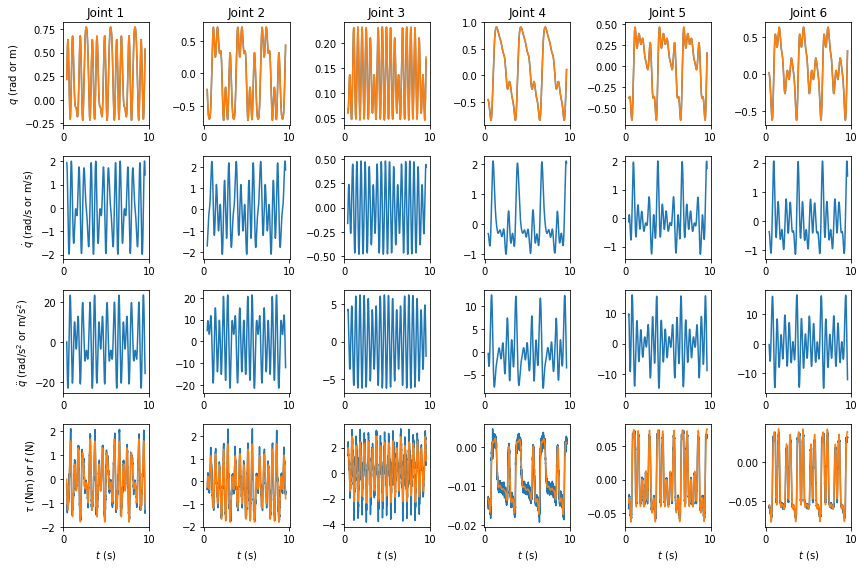

In [304]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

### Test data

q_raw shape: (4989, 6)
plot shape: 460


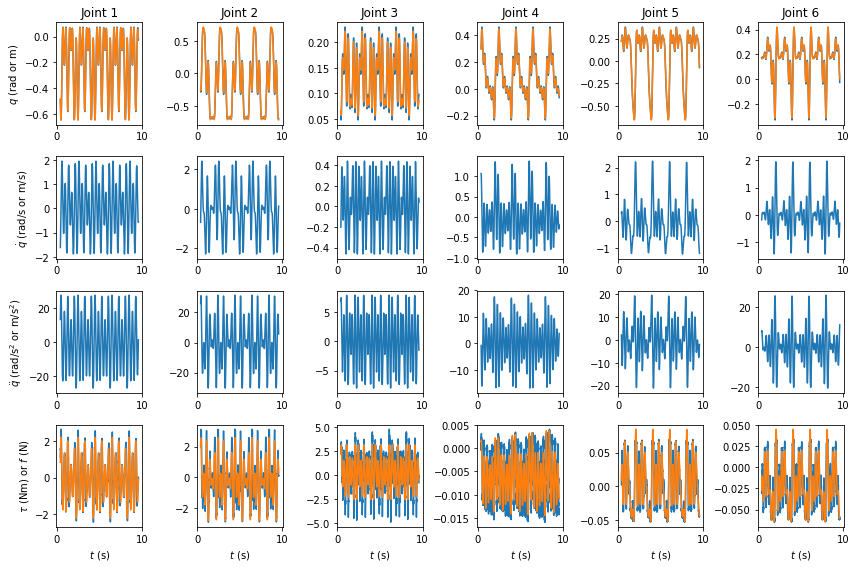

In [305]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [306]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [307]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [308]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/home/radian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [309]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 50
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*m9,0.1623213291150594
-0.36018965*l3x - 0.10779909*l3y - 0.36018965*l4x ...,0.027629544624891346
0.10779909*l3x - 0.36018965*l3y + 0.10779909*l4x -...,-0.015615751084317146
1.0*m11,0.41459477832673924
-0.37597504*l1y - 0.37597504*l3z - 0.37597504*l4z ...,0.005978350933528952
1.0*l11z + 0.59782515*l3x + 0.17891964*l3y + 0.597...,-0.09828392095760703
1.0*l11x - 0.17891964*l3x + 0.59782515*l3y - 0.178...,0.06066702886108382
1.0*l11y + 0.62402496*l1y + 0.62402496*l3z + 0.624...,0.006848875766806241
1.0*l7y,4.143731352597397
-0.27468079*L11xx + 1.0*L3xy + 1.0*L4xy - 0.274680...,0.0852191939361188


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [310]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [311]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0004780385124971609
standard deviation of xb using OLS:
[2.23532014e-04 9.64899002e-05 1.09924654e-04 4.33802681e-04
 3.96126602e-04 9.54757367e-05 1.75971325e-04 6.58254904e-04
 6.99225114e-02 1.05259657e-03 1.58792984e-04 8.01087466e-05
 2.94966364e-03 5.19580270e-04 6.91074234e-05 7.34718281e-04
 2.38213918e-03 7.31194770e-04 7.08800990e-04 4.95344189e-05
 8.83151367e-05 4.74489532e-05 5.59086174e-04 5.59842720e-03
 3.38867647e-02 3.38811188e-04 3.35169455e-04 3.99924375e-04
 2.20401090e-03 1.03017931e-02 3.45341591e-03 6.76977680e-04
 5.66176878e-04 4.90142854e-04 6.06989338e-04 6.24380010e-04
 6.93352335e-04 1.03462966e-01]
percentage of standard deviation of xb using OLS: 
[1.37709576e-03 3.49227255e-03 7.03934468e-03 1.04632934e-03
 6.62601789e-02 9.71427837e-04 2.90060892e-03 9.61113804e-02
 1.68742868e-02 1.23516372e-02 2.85482284e-02 4.29942849e-02
 2.05974433e-02 3.19855971e-03 2.23780367e-01 2.19740398e-01
 1.11182259e-03 2.84191845

### Plot measured torque and predicted torque

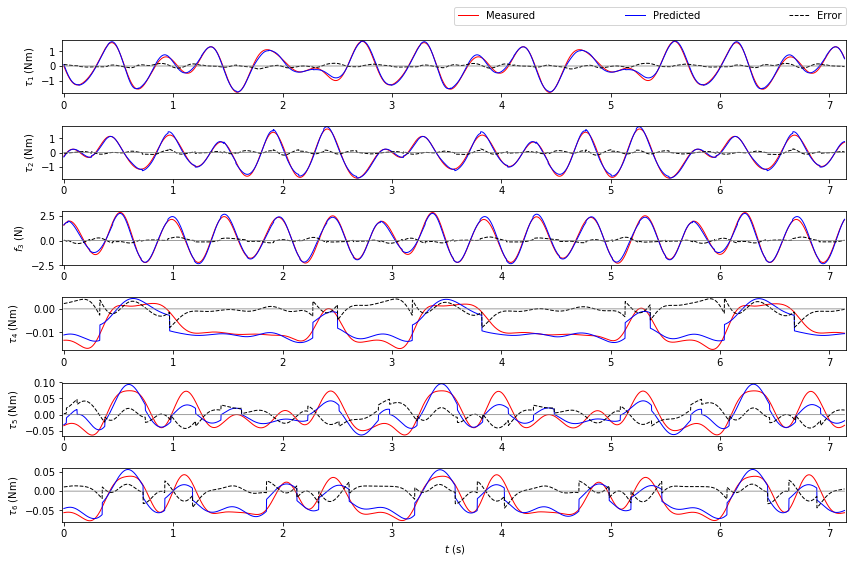

In [312]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [313]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

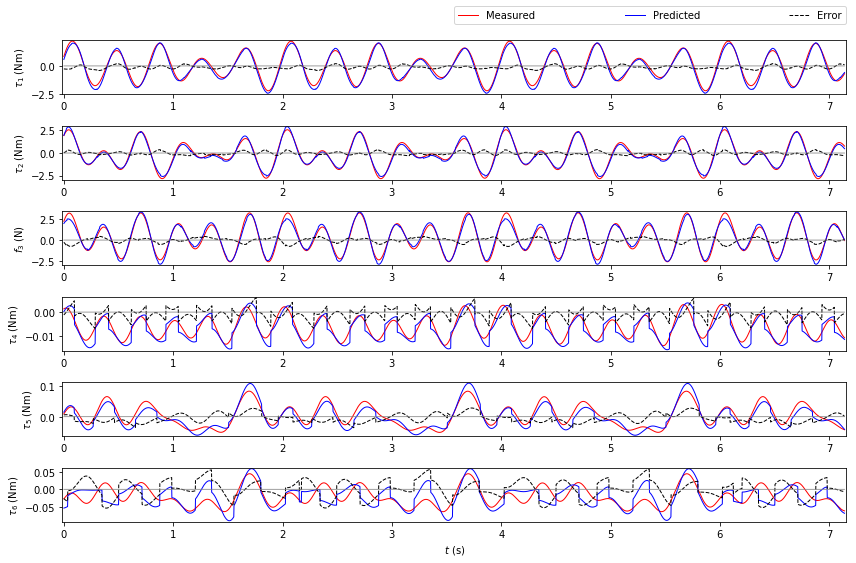

In [316]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [317]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.15460814, 0.12173968, 0.16137613, 0.28276485, 0.41061362,
       0.78134663])

## Weighted Least Square (WLS)

### Training data set

In [192]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight

array([3.72357067, 3.99008701, 6.27781052, 0.02114778, 0.12976102,
       0.11008508])

In [88]:
W_b_train.shape, tau_s_train.shape

In [89]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [90]:
weights.shape

In [91]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [92]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/home/radian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [93]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [94]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

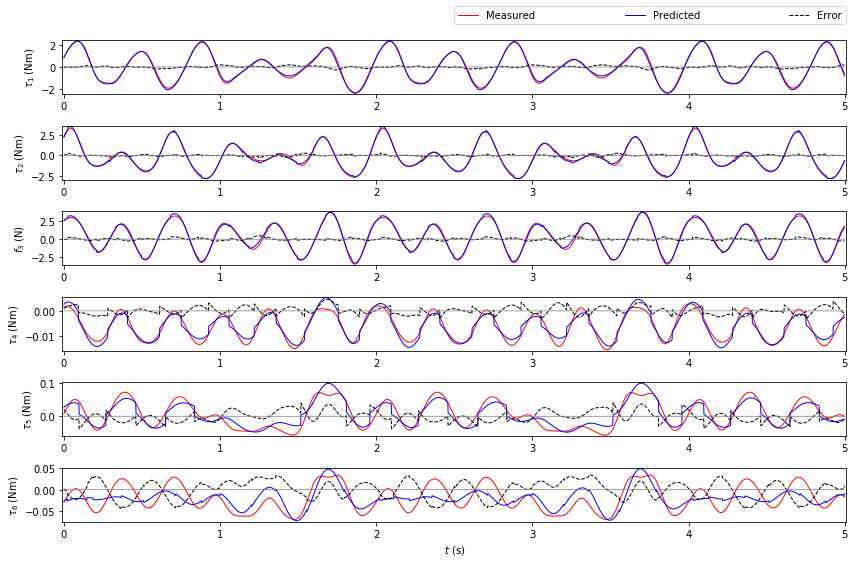

In [95]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type, 
                   robot_model.coordinates)

In [98]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.07186187, 0.06026058, 0.07704187, 0.18791959, 0.38738745,
       0.59728339])

In [35]:
robot_model.bary_param

In [36]:
robot_def.d_coordinates[0] != robot_def.dq_for_frame[1]

False

In [37]:
robot_model.coordinates[1].name[1:]

'2'

In [68]:
robot_model.coordinates.

### Test data set

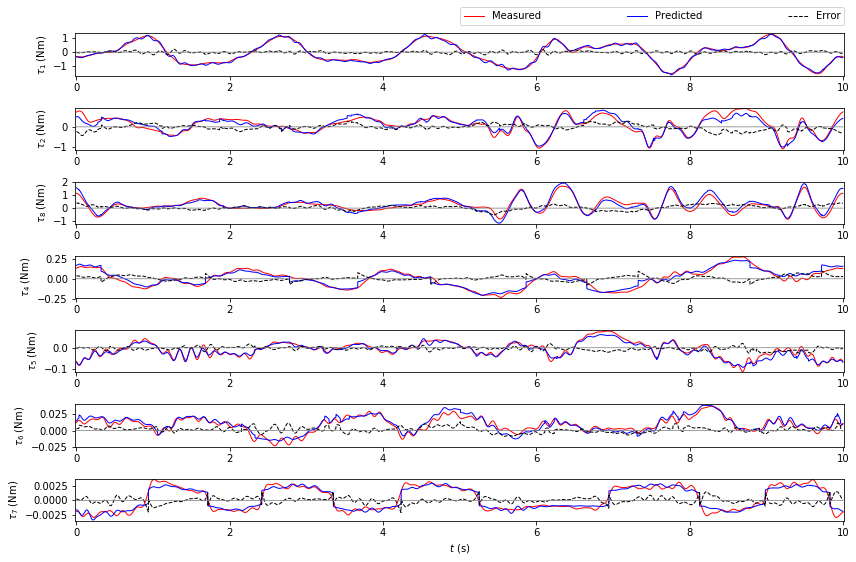

In [69]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [39]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.09882667, 0.32787131, 0.31844911, 0.26594447, 0.25100447,
       0.29643101, 0.24416665])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [40]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [41]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

In [42]:
len(robot_model.std_param)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [43]:
sdp_constraints = []
spring_constraints = []
if model_name == 'mtm' or model_name == 'mtm_2spring_tendon':
    sdp_constraints = [(2, 20, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.2, 0.2, 0.2),
                      (1, 10, -0.1, 0.2, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2),
                      (1, 10, -0.0, 0.3, -0.02, 0.02, -0.01, 0.01, 0.2, 0.2, 0.2),
                      (0.2, 5, -0.01, 0.01, -0.0, 0.1, -0.1, 0.0, 0.2, 0.2, 0.1),
                      (0.1, 2, -0.01, 0.01, -0.05, 0.0, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.05, 0.5, -0.005, 0.005, -0.00, 0.05, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.05, 0.5, -0.000, 0.000, -0.00, 0.00, -0.00, 0.05, 0.1, 0.1, 0.1),
                      (1, 10, -0.10, 0.05, -0.05, 0.05, -0.05, 0.05, 0.1, 0.2, 0.2),
                      (0.05, 0.5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1),
                      (0.0, 0, 0.00, 0.00, -0.00, 0.00, 0.000, 0.00, 0.1, 0.1, 0.0)]
    spring_constraints = [(250, 300), (0.001, 0.1)]
elif model_name == 'mtm_3links':
    sdp_constraints = [(0.5, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.5, 0.5, 0.5),
                      (0.3, 5, -0.1, 0.2, -0.05, 0.05, -0.05, 0.05, 0.5, 0.5, 0.5),
                      (0.1, 3, -0.0, 0.3, -0.02, 0.02, -0.01, 0.01, 0.1, 0.5, 0.5),
                      (0.1, 1, -0.01, 0.01, -0.0, 0.1, -0.1, 0.0, 0.1, 0.1, 0.1),
                      (0.02, 0.3, -0.01, 0.01, -0.05, 0.0, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.02, 0.2, -0.005, 0.005, -0.00, 0.05, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.01, 0.1, -0.000, 0.000, -0.00, 0.00, -0.00, 0.05, 0.1, 0.1, 0.1),
                      (0.3, 5, -0.10, 0.05, -0.05, 0.05, -0.05, 0.05, 0.5, 0.5, 0.5),
                      (0.3, 5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1),
                      (0.3, 5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1)]
else:
    raise Exception("No robot name matches " + model_name)

In [57]:


sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model,
                     sdp_constraints, spring_constraints)
# sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
%time sdp_opt_std.solve()

Regressor shape: (102123, 122)
Regressand shape: (102123,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 4727149, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
Variables n = 123, constraints m = 102451
Cones:	linear vars: 137
	soc vars: 102125, soc blks: 1
	sd vars: 189, sd blks: 9
Setup time: 1.93e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.39e+01  9.74e-01  1.00e+00 -1.02e+04 -2.26e-03  5.06e-12  2.32

  9400| 8.11e-02  2.56e-05  2.82e-04  4.45e-01  4.45e-01  2.11e-12  5.98e+02 
  9500| 8.11e-02  1.20e-05  2.86e-04  4.49e-01  4.50e-01  4.21e-13  6.04e+02 
  9600| 8.11e-02  4.14e-05  2.89e-04  4.54e-01  4.55e-01  2.11e-12  6.10e+02 
  9700| 8.11e-02  6.02e-05  2.95e-04  4.59e-01  4.59e-01  2.11e-12  6.15e+02 
  9800| 8.10e-02  7.32e-05  3.01e-04  4.63e-01  4.64e-01  4.21e-13  6.20e+02 
  9900| 8.10e-02  7.41e-05  3.06e-04  4.68e-01  4.69e-01  4.21e-13  6.26e+02 
 10000| 8.11e-02  6.43e-05  3.09e-04  4.73e-01  4.73e-01  1.26e-12  6.31e+02 
 10100| 8.11e-02  4.79e-05  3.13e-04  4.77e-01  4.78e-01  2.95e-12  6.37e+02 
 10200| 8.11e-02  2.24e-05  3.18e-04  4.82e-01  4.83e-01  2.11e-12  6.42e+02 
 10300| 8.11e-02  1.49e-05  3.23e-04  4.87e-01  4.88e-01  4.21e-13  6.47e+02 
 10400| 8.11e-02  3.03e-05  3.28e-04  4.92e-01  4.92e-01  1.26e-12  6.53e+02 
 10500| 8.11e-02  4.94e-05  3.31e-04  4.96e-01  4.97e-01  2.95e-12  6.58e+02 
 10600| 8.10e-02  6.10e-05  3.35e-04  5.01e-01  5.02e-01  1.26e-

 20000| 8.10e-02  3.00e-06  6.10e-04  9.43e-01  9.45e-01  4.21e-13  1.13e+03 
 20100| 8.10e-02  7.14e-06  6.12e-04  9.48e-01  9.49e-01  4.21e-13  1.14e+03 
 20200| 8.10e-02  5.26e-06  6.14e-04  9.52e-01  9.54e-01  2.95e-12  1.14e+03 
 20300| 8.10e-02  8.82e-06  6.16e-04  9.57e-01  9.59e-01  4.21e-13  1.15e+03 
 20400| 8.10e-02  9.51e-06  6.18e-04  9.62e-01  9.64e-01  4.21e-13  1.15e+03 
 20500| 8.10e-02  8.59e-06  6.20e-04  9.66e-01  9.68e-01  4.21e-13  1.16e+03 
 20600| 8.10e-02  9.54e-06  6.22e-04  9.71e-01  9.73e-01  4.21e-13  1.16e+03 
 20700| 8.10e-02  5.09e-06  6.24e-04  9.76e-01  9.78e-01  4.21e-13  1.17e+03 
 20800| 8.10e-02  6.79e-06  6.26e-04  9.81e-01  9.82e-01  4.21e-13  1.17e+03 
 20900| 8.10e-02  3.99e-06  6.28e-04  9.85e-01  9.87e-01  1.26e-12  1.18e+03 
 21000| 8.10e-02  5.73e-06  6.29e-04  9.90e-01  9.92e-01  2.95e-12  1.18e+03 
 21100| 8.10e-02  7.98e-06  6.31e-04  9.95e-01  9.97e-01  1.26e-12  1.18e+03 
 21200| 8.10e-02  6.89e-06  6.33e-04  9.99e-01  1.00e+00  1.26e-

 30600| 8.09e-02  4.20e-06  7.56e-04  1.44e+00  1.44e+00  1.27e-12  1.66e+03 
 30700| 8.09e-02  2.63e-06  7.57e-04  1.45e+00  1.45e+00  2.11e-12  1.67e+03 
 30800| 8.09e-02  3.41e-06  7.58e-04  1.45e+00  1.45e+00  1.27e-12  1.67e+03 
 30900| 8.09e-02  3.81e-06  7.59e-04  1.45e+00  1.46e+00  4.22e-13  1.68e+03 
 31000| 8.09e-02  2.39e-06  7.59e-04  1.46e+00  1.46e+00  1.27e-12  1.68e+03 
 31100| 8.09e-02  4.30e-06  7.60e-04  1.46e+00  1.47e+00  1.27e-12  1.68e+03 
 31200| 8.09e-02  2.18e-06  7.61e-04  1.47e+00  1.47e+00  1.27e-12  1.69e+03 
 31300| 8.09e-02  3.89e-06  7.62e-04  1.47e+00  1.48e+00  2.95e-12  1.69e+03 
 31400| 8.09e-02  3.12e-06  7.63e-04  1.48e+00  1.48e+00  4.22e-13  1.70e+03 
 31500| 8.09e-02  2.84e-06  7.64e-04  1.48e+00  1.49e+00  2.11e-12  1.70e+03 
 31600| 8.09e-02  3.98e-06  7.65e-04  1.49e+00  1.49e+00  4.22e-13  1.71e+03 
 31700| 8.09e-02  2.07e-06  7.66e-04  1.49e+00  1.50e+00  2.11e-12  1.71e+03 
 31800| 8.09e-02  4.15e-06  7.67e-04  1.50e+00  1.50e+00  4.22e-

 41200| 8.08e-02  2.98e-06  8.35e-04  1.94e+00  1.94e+00  2.96e-12  2.15e+03 
 41300| 8.08e-02  3.01e-06  8.35e-04  1.94e+00  1.95e+00  4.22e-13  2.15e+03 
 41400| 8.08e-02  3.36e-06  8.36e-04  1.95e+00  1.95e+00  1.27e-12  2.16e+03 
 41500| 8.08e-02  2.70e-06  8.36e-04  1.95e+00  1.96e+00  1.27e-12  2.16e+03 
 41600| 8.08e-02  3.46e-06  8.37e-04  1.96e+00  1.96e+00  1.27e-12  2.17e+03 
 41700| 8.08e-02  2.79e-06  8.37e-04  1.96e+00  1.96e+00  4.22e-13  2.17e+03 
 41800| 8.08e-02  3.24e-06  8.38e-04  1.97e+00  1.97e+00  1.27e-12  2.17e+03 
 41900| 8.08e-02  3.16e-06  8.38e-04  1.97e+00  1.97e+00  4.22e-13  2.18e+03 
 42000| 8.08e-02  2.87e-06  8.39e-04  1.97e+00  1.98e+00  1.27e-12  2.18e+03 
 42100| 8.08e-02  3.43e-06  8.39e-04  1.98e+00  1.98e+00  4.22e-13  2.19e+03 
 42200| 8.08e-02  2.72e-06  8.40e-04  1.98e+00  1.99e+00  4.22e-13  2.19e+03 
 42300| 8.08e-02  3.39e-06  8.40e-04  1.99e+00  1.99e+00  1.27e-12  2.20e+03 
 42400| 8.08e-02  2.96e-06  8.41e-04  1.99e+00  2.00e+00  4.22e-

## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [58]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [59]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.07897814, 0.31287993, 0.17930951, 0.26768465, 0.29612818,
       0.2220772 , 0.26818115])

### Plot measured torque and predicted torque

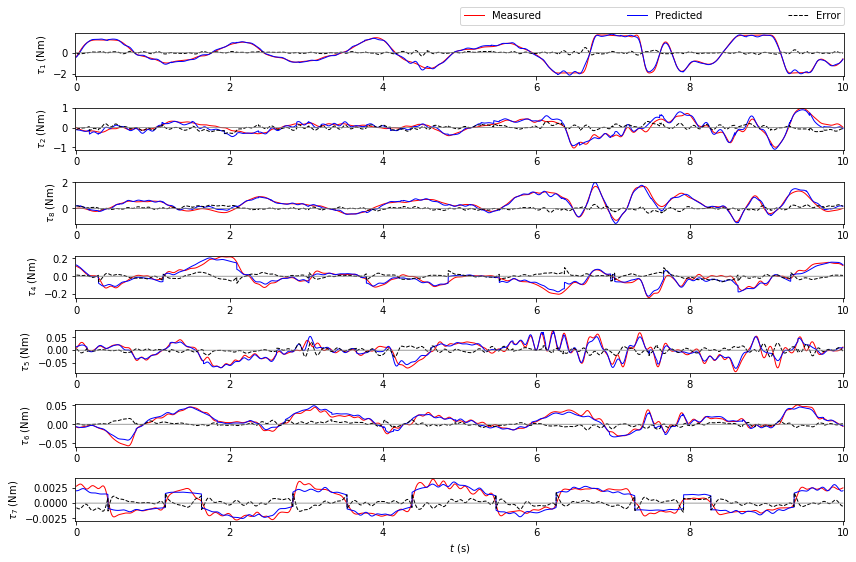

In [73]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [61]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

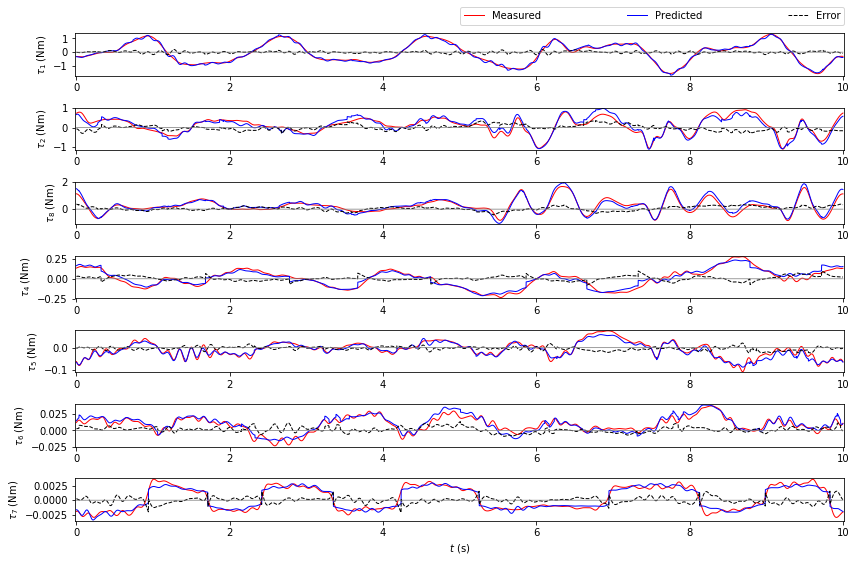

In [74]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [63]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.09879577, 0.32548518, 0.28563868, 0.25714807, 0.25187338,
       0.29823386, 0.24384046])

In [64]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx     2.6343054888674   ⎤
⎢                           ⎥
⎢L1xy  -4.46223463925424e-14⎥
⎢                           ⎥
⎢L1xz  9.56844769208569e-24 ⎥
⎢                           ⎥
⎢L1yy    2.63430548886742   ⎥
⎢                           ⎥
⎢L1yz  1.11467480731081e-17 ⎥
⎢                           ⎥
⎢L1zz   8.48601005291674e-6 ⎥
⎢                           ⎥
⎢l1x   5.85046325777972e-23 ⎥
⎢                           ⎥
⎢l1y   -1.89889430298544e-17⎥
⎢                           ⎥
⎢l1z     0.515973583715752  ⎥
⎢                           ⎥
⎢ m₁     3.82378587565491   ⎥
⎢                           ⎥
⎢Fc₁    0.0319006663095601  ⎥
⎢                           ⎥
⎢Fv₁    0.0552209852590067  ⎥
⎢                           ⎥
⎢Fo₁    -0.0608126942836563 ⎥
⎢                           ⎥
⎢L2xx   0.0185035212076023  ⎥
⎢                           ⎥
⎢L2xy   0.00633619756614463 ⎥
⎢                           ⎥
⎢L2xz   0.00250272253380045 ⎥
⎢                           ⎥
⎢L2yy    0.013261627741961  ⎥
⎢         

In [65]:
from identification import barycentric2standard_params

In [66]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

In [67]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

⎡I1xx    2.56468110409537   ⎤
⎢                           ⎥
⎢I1xy  -4.46223463925424e-14⎥
⎢                           ⎥
⎢I1xz  1.74629391507553e-23 ⎥
⎢                           ⎥
⎢I1yy    2.56468110409538   ⎥
⎢                           ⎥
⎢I1yz  8.58442023763276e-18 ⎥
⎢                           ⎥
⎢I1zz   8.48601005291674e-6 ⎥
⎢                           ⎥
⎢r1x    1.5300185334718e-23 ⎥
⎢                           ⎥
⎢r1y   -4.96600585057657e-18⎥
⎢                           ⎥
⎢r1z     0.134937886297668  ⎥
⎢                           ⎥
⎢ m₁     3.82378587565491   ⎥
⎢                           ⎥
⎢Fc₁    0.0319006663095601  ⎥
⎢                           ⎥
⎢Fv₁    0.0552209852590067  ⎥
⎢                           ⎥
⎢Fo₁    -0.0608126942836563 ⎥
⎢                           ⎥
⎢I2xx   0.0176099112247765  ⎥
⎢                           ⎥
⎢I2xy   0.00433958872950056 ⎥
⎢                           ⎥
⎢I2xz   -2.8759159057212e-5 ⎥
⎢                           ⎥
⎢I2yy   0.00107829944199846 ⎥
⎢         